<a href="https://colab.research.google.com/github/lahiiru/image-to-html-table-example/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup unitable for table structure recognition

In [ ]:
!git clone https://github.com/poloclub/unitable.git
%cd /content/unitable
%pip install -r requirements.txt
!make .done_download_weights

In [4]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML

from typing import Tuple, List, Sequence, Optional, Union
from pathlib import Path
import re
import torch
import tokenizers as tk
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import transforms
from torch import nn, Tensor
from functools import partial
from bs4 import BeautifulSoup as bs
import warnings

from src.model import EncoderDecoder, ImgLinearBackbone, Encoder, Decoder
from src.utils import subsequent_mask, pred_token_within_range, greedy_sampling, bbox_str_to_token_list, cell_str_to_token_list, html_str_to_token_list, build_table_from_html_and_cell, html_table_template
from src.vocab import (
    HTML_TOKENS,
    TASK_TOKENS,
    RESERVED_TOKENS,
    BBOX_TOKENS,
)


VALID_HTML_TOKEN = ["<eos>"] + HTML_TOKENS
INVALID_CELL_TOKEN = (
    ["<sos>", "<pad>", "<empty>", "<sep>"] + TASK_TOKENS + RESERVED_TOKENS
)
VALID_BBOX_TOKEN = [
    "<eos>"
] + BBOX_TOKENS  # image size will be addressed after instantiation
warnings.filterwarnings('ignore')
device = torch.device("cuda:0")

In [ ]:
%cd /content/unitable/src

In [6]:
# Check all model weights have been downloaded to experiments/unitable_weights
MODEL_FILE_NAME = ["unitable_large_structure.pt", "unitable_large_bbox.pt", "unitable_large_content.pt"]
MODEL_DIR = Path("../experiments/unitable_weights")

assert all([(MODEL_DIR / name).is_file() for name in MODEL_FILE_NAME]), f"Please download model weights from HuggingFace: https://huggingface.co/poloclub/UniTable/tree/main"

In [7]:
# UniTable large model
d_model = 768
patch_size = 16
nhead = 12
dropout = 0.2

backbone = ImgLinearBackbone(d_model=d_model, patch_size=patch_size)
encoder = Encoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=12,
    ff_ratio=4,
)
decoder = Decoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=4,
    ff_ratio=4,
)

In [8]:
def autoregressive_decode(
    model: EncoderDecoder,
    image: Tensor,
    prefix: Sequence[int],
    max_decode_len: int,
    eos_id: int,
    token_whitelist: Optional[Sequence[int]] = None,
    token_blacklist: Optional[Sequence[int]] = None,
) -> Tensor:
    model.eval()
    with torch.no_grad():
        memory = model.encode(image)
        context = torch.tensor(prefix, dtype=torch.int32).repeat(image.shape[0], 1).to(device)

    for _ in range(max_decode_len):
        eos_flag = [eos_id in k for k in context]
        if all(eos_flag):
            break

        with torch.no_grad():
            causal_mask = subsequent_mask(context.shape[1]).to(device)
            logits = model.decode(
                memory, context, tgt_mask=causal_mask, tgt_padding_mask=None
            )
            logits = model.generator(logits)[:, -1, :]

        logits = pred_token_within_range(
            logits.detach(),
            white_list=token_whitelist,
            black_list=token_blacklist,
        )

        next_probs, next_tokens = greedy_sampling(logits)
        context = torch.cat([context, next_tokens], dim=1)
    return context

def load_vocab_and_model(
    vocab_path: Union[str, Path],
    max_seq_len: int,
    model_weights: Union[str, Path],
) -> Tuple[tk.Tokenizer, EncoderDecoder]:
    vocab = tk.Tokenizer.from_file(vocab_path)
    model = EncoderDecoder(
        backbone=backbone,
        encoder=encoder,
        decoder=decoder,
        vocab_size=vocab.get_vocab_size(),
        d_model=d_model,
        padding_idx=vocab.token_to_id("<pad>"),
        max_seq_len=max_seq_len,
        dropout=dropout,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )

    model.load_state_dict(torch.load(model_weights, map_location="cpu"))
    model = model.to(device)
    return vocab, model

def image_to_tensor(image: Image, size: Tuple[int, int]) -> Tensor:
    T = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.86597056,0.88463002,0.87491087], std = [0.20686628,0.18201602,0.18485524])
    ])
    image_tensor = T(image)
    image_tensor = image_tensor.to(device).unsqueeze(0)

    return image_tensor

def rescale_bbox(
    bbox: Sequence[Sequence[float]],
    src: Tuple[int, int],
    tgt: Tuple[int, int]
) -> Sequence[Sequence[float]]:
    assert len(src) == len(tgt) == 2
    ratio = [tgt[0] / src[0], tgt[1] / src[1]] * 2
    bbox = [[int(round(i * j)) for i, j in zip(entry, ratio)] for entry in bbox]
    return bbox

In [49]:
from time import sleep
def extract_table_content_using_unitable(_image):
  # Table structure extraction
  vocab, model = load_vocab_and_model(
      vocab_path="../vocab/vocab_html.json",
      max_seq_len=784,
      model_weights=MODEL_DIR / MODEL_FILE_NAME[0],
  )

  # Image transformation
  image_tensor = image_to_tensor(_image, size=(448, 448))

  # Inference
  pred_html = autoregressive_decode(
      model=model,
      image=image_tensor,
      prefix=[vocab.token_to_id("[html]")],
      max_decode_len=512,
      eos_id=vocab.token_to_id("<eos>"),
      token_whitelist=[vocab.token_to_id(i) for i in VALID_HTML_TOKEN],
      token_blacklist = None
  )

  # Convert token id to token text
  pred_html = pred_html.detach().cpu().numpy()[0]
  pred_html = vocab.decode(pred_html, skip_special_tokens=False)
  pred_html = html_str_to_token_list(pred_html)

  # print(pred_html)

  # Table cell bbox detection
  vocab, model = load_vocab_and_model(
      vocab_path="../vocab/vocab_bbox.json",
      max_seq_len=1024,
      model_weights=MODEL_DIR / MODEL_FILE_NAME[1],
  )

  # Image transformation
  image_tensor = image_to_tensor(_image, size=(448, 448))

  # Inference
  pred_bbox = autoregressive_decode(
      model=model,
      image=image_tensor,
      prefix=[vocab.token_to_id("[bbox]")],
      max_decode_len=1024,
      eos_id=vocab.token_to_id("<eos>"),
      token_whitelist=[vocab.token_to_id(i) for i in VALID_BBOX_TOKEN[: 449]],
      token_blacklist = None
  )

  # Convert token id to token text
  pred_bbox = pred_bbox.detach().cpu().numpy()[0]
  pred_bbox = vocab.decode(pred_bbox, skip_special_tokens=False)

  # print(pred_bbox)

  # Visualize detected bbox
  pred_bbox = bbox_str_to_token_list(pred_bbox)
  pred_bbox = rescale_bbox(pred_bbox, src=(448, 448), tgt=_image.size)

  fig, ax = plt.subplots(figsize=(12, 10))
  for i in pred_bbox:
      rect = patches.Rectangle(i[:2], i[2] - i[0], i[3] - i[1], linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
  ax.set_axis_off()
  ax.imshow(_image)
  fig.canvas.draw()
  sleep(0.1)

  # Table cell content recognition
  vocab, model = load_vocab_and_model(
      vocab_path="../vocab/vocab_cell_6k.json",
      max_seq_len=200,
      model_weights=MODEL_DIR / MODEL_FILE_NAME[2],
  )

  # Cell image cropping and transformation
  image_tensor = [image_to_tensor(_image.crop(bbox), size=(112, 448)) for bbox in pred_bbox]
  image_tensor = torch.cat(image_tensor, dim=0)

  # Inference
  pred_cell = autoregressive_decode(
      model=model,
      image=image_tensor,
      prefix=[vocab.token_to_id("[cell]")],
      max_decode_len=200,
      eos_id=vocab.token_to_id("<eos>"),
      token_whitelist=None,
      token_blacklist = [vocab.token_to_id(i) for i in INVALID_CELL_TOKEN]
  )

  # Convert token id to token text
  pred_cell = pred_cell.detach().cpu().numpy()
  pred_cell = vocab.decode_batch(pred_cell, skip_special_tokens=False)
  pred_cell = [cell_str_to_token_list(i) for i in pred_cell]
  pred_cell = [re.sub(r'(\d).\s+(\d)', r'\1.\2', i) for i in pred_cell]

  # Combine the table structure and cell content
  pred_code = build_table_from_html_and_cell(pred_html, pred_cell)
  pred_code = "".join(pred_code)
  pred_code = html_table_template(pred_code)

  # Display the HTML table
  soup = bs(pred_code)
  table_code = soup.prettify()
  return table_code

# Setup PaddleOCR for table ROI detection

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install paddlepaddle-gpu paddleocr

In [39]:
from paddleocr import PPStructure, draw_structure_result, save_structure_res
import cv2
import numpy as np

import matplotlib.pyplot as plt

def detect_first_table(image_path):
  table_engine = PPStructure(show_log=True,use_gpu=True)

  table_bbox = None
  result = table_engine(image_path)
  for structure in result:
      if structure["type"] == "table":
          table_bbox = structure['bbox']
          return table_bbox

# Do the image to HTML table conversion
I'm using HTML instead of CSV due to two reasons.
- HTML is cabable of representing tables more correctly than CSV when it has merged columns
- unitable has not given vocab json for CSV


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[2024/10/13 16:06:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl

Time,Amount ( fast ),B = Test ( β = 60 ),Components ( C = 2016 ),BPP,---- B / A
< underline >- underline >-< underline > O underline >,0,0,O,___,Journal
0.25,5.74 0 ± 17.2,2.460 ± 10,0.950 + 3.93,259,0.42
0.50,60.63 ± 41.9,27.41 ± 39,38.12 + 42.7,0.72,0.45
0.75,142.4 ± 50.3,67.51 ± 70,86.19 + 67.3,0.78,0.47
1.00,181.7 ± 55,103.0 ± 80,139.9 ± 90.6,0.74,OR
1.25,207.1 ± 35.2,140.0 + 78,168.0 + 89.0,0.83,0.62
1.50,212.7 ± 38.1,170.1 + 66,184.9 ± 83,0.92,0.80
1.75,207.4 ± 35.1,182.8 + 51,189.0 + 82.0,0.97,0.222
2.00,215.0 ± 28.3,192.7 ± 57,205.94 - 77,0.94,0.95
2.50,208.7 ± 29.5,204.4 ± 37,215.5 ± 557.3,0.05,0.000


[2024/10/13 16:08:14] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

[2024/10/13 16:08:28] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

[2024/10/13 16:09:08] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

[2024/10/13 16:09:43] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

[2024/10/13 16:10:17] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

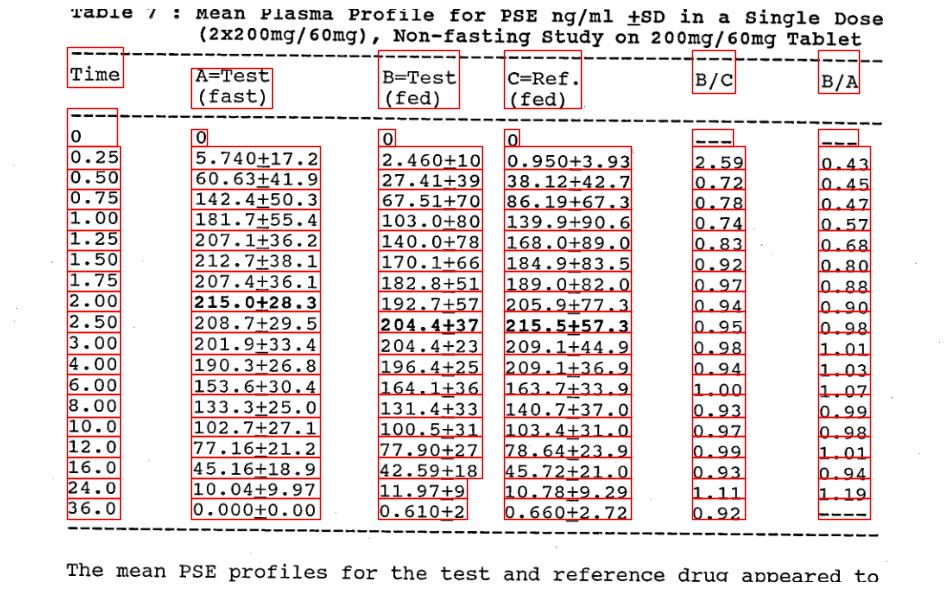

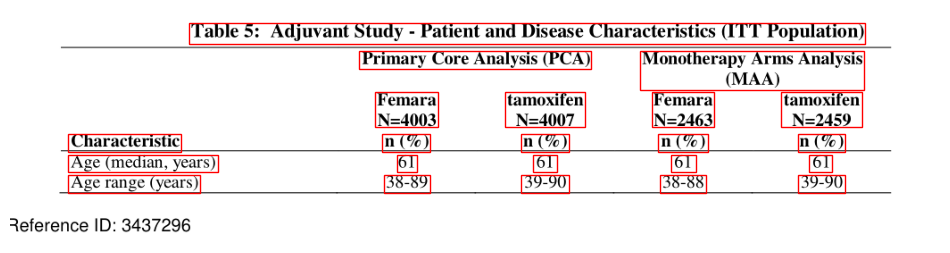

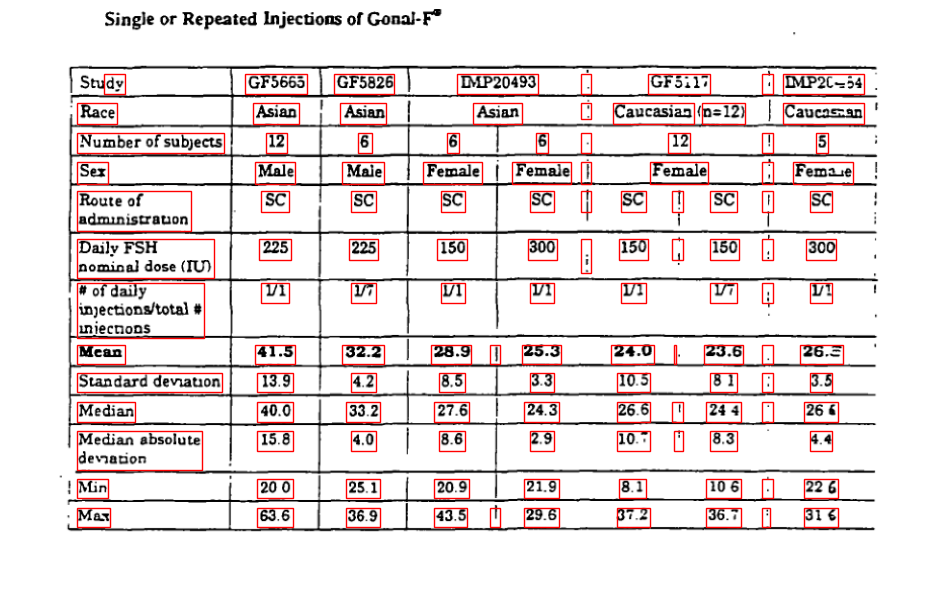

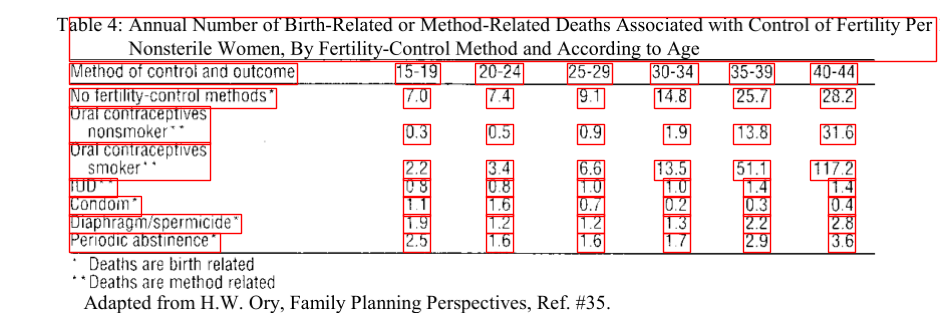

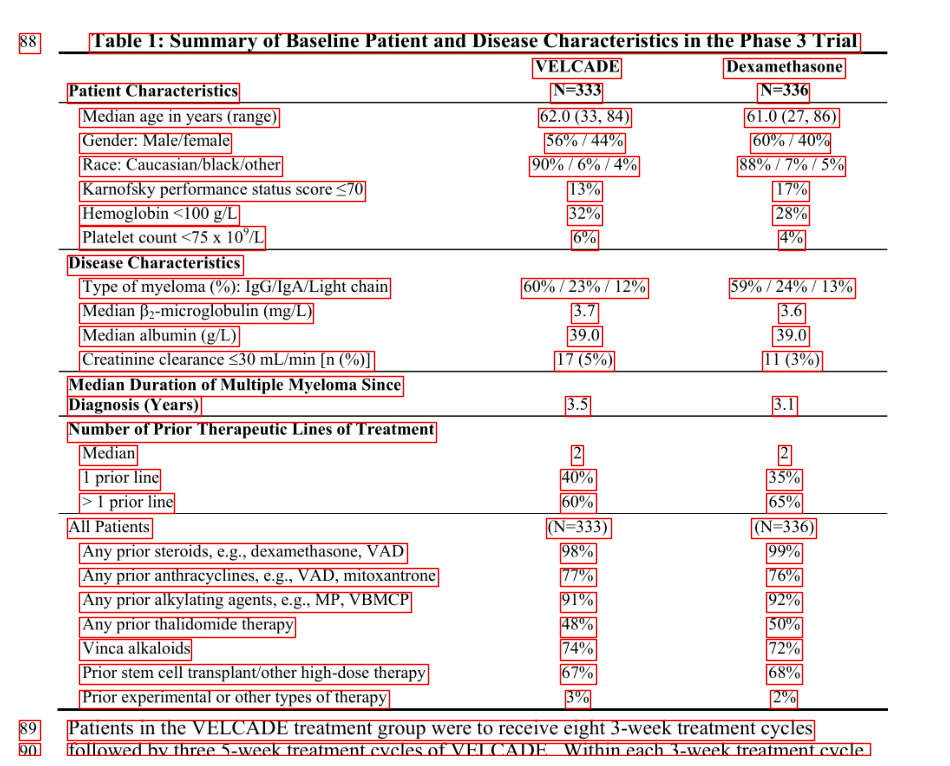

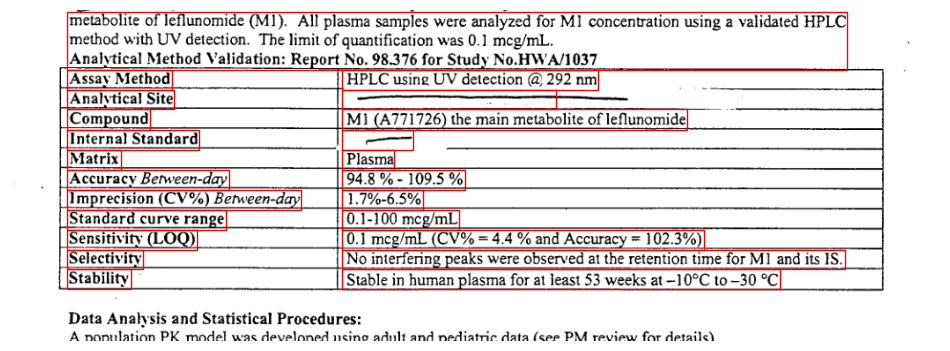

In [50]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image, ImageOps
import os
image_dir = "/content/drive/Shareddrives/personal/idp_bootcamp/week_3/assingment_data"
out_path = "/content/drive/Shareddrives/personal/idp_bootcamp/week_3/week_3_assignment/csv_outs"
# loop though all png files in img_dir
for image_name in os.listdir(image_dir):
  if image_name.endswith(".png"):
    image_path = os.path.join(image_dir, image_name)

    table_bbox = detect_first_table(image_path)
    if table_bbox:
      x_min, y_min, x_max, y_max = table_bbox
      padding = 50
      x_min = max(0, x_min - padding)
      y_min = max(0, y_min - padding)
      image_cv2 = cv2.imread(image_path)
      x_max = min(image_cv2.shape[1], x_max + padding)
      y_max = min(image_cv2.shape[0], y_max + padding)

      table_bbox_padded = [x_min, y_min, x_max, y_max]
      img = Image.fromarray(image_cv2).crop(table_bbox_padded)
      html = extract_table_content_using_unitable(img)
      display(HTML(html))
      # write html to disk
      with open(f"{out_path}/{image_name.replace('.png', 'html')}", "w") as f:
          f.write(html)